## Clustering and Regression Modeling for Computationally Generated Organic Small Molecules

### Author: Robert Manriquez

github.com/robertmanriquez

##### Part I.  Abstract

This work involves doing the standard method of performing feature engineering, exploratory data analysis, and building machine learning models.  Use Sci-Kit Learn's library, it was possible to create simple models for predicting desirable three desirable materials properties: HOMO and LUMO values (important for designing photophysical applications such as dyes, phototincs, or organic semiconductors like OLEDs) and polarizability (important for crystallography in determine crystal structures).  These 3 properties are intimately related; the HOMO, LUMO, and gap between the two determine how a molecule will interact with sources of radiation (visible light, UV, etc) and dictate how it will transfer electronics between other molecules while polarizability dictates how the intramolecular packing modes and how it will form crystal structures, which ultimately affect it's properties as an electronic material.  First, K-Means clustering was used to produce extra features that may unearth non-obvious trends in the data.  Second, these features were included with the other columns of this dataset to be included in building machine learning models.

##### Part II.  Introduction and Objectives

In this work, it was possible to convert a computationally generated dataset of small molecule organic molecules obtained by Ramakrishnan et al [1] into a data frame with relevent features that can are ready for data analysis and machine learning applications. This work serves two purposes:


1) To share a method of parsing Ramakrishnan's dataset into a usable format.  As it was distributed online, it was a collection of over 100,000 individual text files with relevant chemical information presented as plain text, which can be cumbersome to use in most basic data analysis methods.  This notebook uses the .csv format output, while the .pif format is also available for use with Citrine's propriety software.


2) To demonstrate that it is possible to use a large data set like Ramakrishnan's to build a useful predictive model, with just open source tools and without the need for computationally expensive methods like DFT calculations or molecular simulations.  Although building predictions on a computationally generated data set is not a best practice, it is still a great model dataset to prototype machine learning applications.  Ultimately, the objective is to demonstrate how accessible power of open source ML, data analysis, and chemical informatics can be and to encourage the everyday scientist to incorporate these tools into their workflow.  Since this is such a large dataset, it can also be a great source of additional synthetic training data to include with one's experimental data, since often in the lab environment it's difficult to amass enough data to build a robust machine learning model.


Although this approach should never replace sophisticated scientific software nor conventional scientific methods, machine learning and big data techniques can be used alongside these tools to enhance data-driven research and development.  Whether it's reducing the amount of experiments needed to acheive a key result, deciding which combinations of reagents to mix, or simply helping a scientist learn where to look for discovering a new material, data science is going to be an increasingly important tool for any scientist or engineer.


#### Part III. Methodology: Data Prep and Exploratory Data Analysis

In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
pd.set_option("max.columns", 100)

In [3]:
df = pd.read_csv('./all_dsgdb.csv')

In [4]:
df.head()

,i,n_atoms,A,B,C,u,alpha,HOMO,LUMO,HL_gap,<R2>,zpve,U_0K,U_298K,H,G,Cv,Harmonic_freqs,SMILES,InChI,atoms_xyz
0,1,5,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,"[1341.307, 1341.3284, 1341.365, 1562.6731, 156...","['C', 'C']","['InChI=1S/CH4/h1H4', 'InChI=1S/CH4/h1H4']",C\t-0.0126981359\t 1.0858041578\t 0.0080009958...
1,2,4,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,"[1103.8733, 1684.1158, 1684.3072, 3458.7145, 3...","['N', 'N']","['InChI=1S/H3N/h1H3', 'InChI=1S/H3N/h1H3']",N\t-0.0404260543\t 1.0241077531\t 0.0625637998...
2,3,3,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,"[1671.4222, 3803.6305, 3907.698]","['O', 'O']","['InChI=1S/H2O/h1H2', 'InChI=1S/H2O/h1H2']",O\t-0.0343604951\t 0.9775395708\t 0.0076015923...
3,4,4,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,"[549.7648, 549.7648, 795.2713, 795.2713, 2078....","['C#C', 'C#C']","['InChI=1S/C2H2/c1-2/h1-2H', 'InChI=1S/C2H2/c1...",C\t 0.5995394918\t 0.\t 1.\t-0.207019\nC\t-0.5...
4,5,3,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,"[799.0101, 799.0101, 2198.4393, 3490.3686]","['C#N', 'C#N']","['InChI=1S/CHN/c1-2/h1H', 'InChI=1S/CHN/c1-2/h...",C\t-0.0133239314\t 1.1324657151\t 0.0082758861...


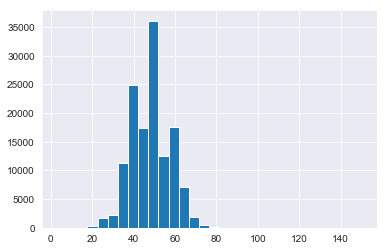

In [5]:
df.Harmonic_freqs.map(lambda x: len(x.replace('[','').replace(']','').split(','))).hist(bins = 30);

In [6]:
def hf_parse(x, lower, upper):
    parsed_freqs = x.replace('[','').replace(']','').split(',')
    return [float(f) for f in parsed_freqs if float(f) > lower and float(f) <= upper]

maximum_possible_hf = df.Harmonic_freqs.map(lambda x: x.replace('[','').replace(']','').split(','))\
                        .map(lambda x: max([float(i) for i in x])).max()

hf_parse("[10,1000,2000]", 500, 1000)
df['HF_below_1000'] = df.Harmonic_freqs.map(lambda x: len(hf_parse(x, 0, 1000)))
df['HF_1000_2000'] = df.Harmonic_freqs.map(lambda x: len(hf_parse(x, 1000, 2000)))
df['HF_above_2000'] = df.Harmonic_freqs.map(lambda x: len(hf_parse(x, 2000, maximum_possible_hf)))

In [7]:
atom_counts = []
atom_list = ['C','H','O','N','F']

for i in df.atoms_xyz.values:

    atom_dict = Counter([atom[0] for atom in i.split('\n')[:-1]])
    
    atom_counts.append([atom_dict[element] for element in atom_list])

In [8]:
atoms_df = pd.DataFrame(data = atom_counts, columns = ['num_' + i for i in atom_list])

In [9]:
df = df.drop(['i','Harmonic_freqs', 'SMILES','InChI', 'atoms_xyz'], axis = 1)

In [10]:
df = pd.concat(objs = [df, atoms_df], axis = 1)

In [11]:
df.shape

(133885, 24)

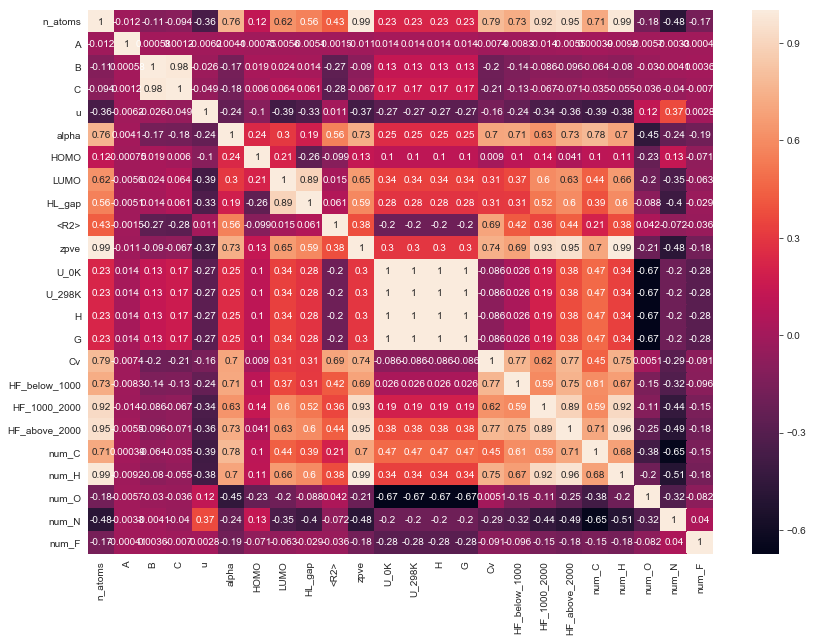

In [12]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True);

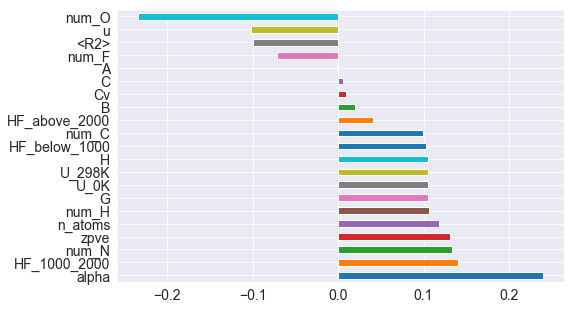

In [13]:
plt.figure(figsize = (8,5))
df.drop(['LUMO','HL_gap'], axis = 1).corr().HOMO.sort_values(ascending = False)[1:].plot(kind = 'barh')
plt.tick_params(labelsize=14)

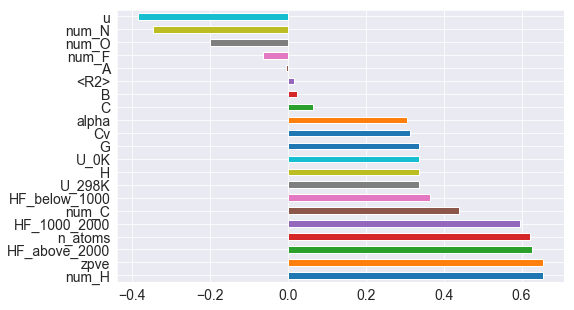

In [14]:
plt.figure(figsize = (8,5))
df.drop(['HOMO','HL_gap'], axis = 1).corr().LUMO.sort_values(ascending = False)[1:].plot(kind = 'barh')
plt.tick_params(labelsize=14)

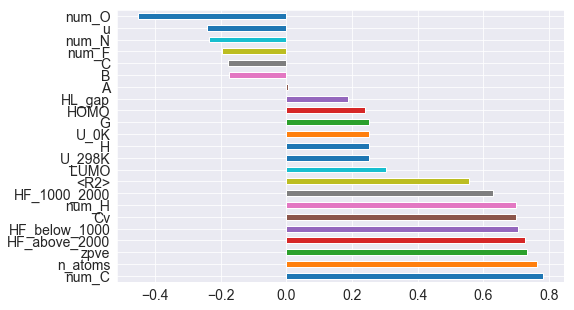

In [15]:
plt.figure(figsize = (8,5))
df.corr().alpha.sort_values(ascending = False)[1:].plot(kind = 'barh')
plt.tick_params(labelsize=14)

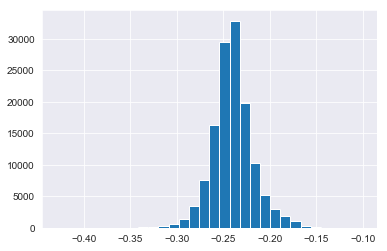

In [16]:
df['HOMO'].hist(bins = 30);

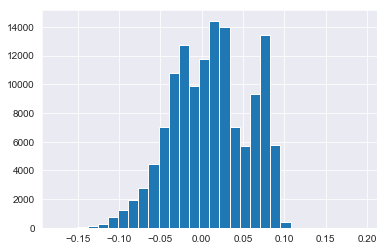

In [17]:
df['LUMO'].hist(bins = 30);

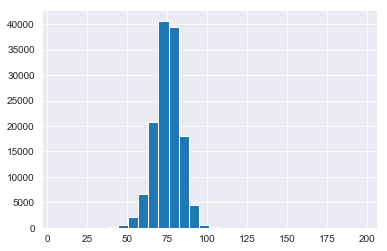

In [18]:
df['alpha'].hist(bins = 30);

In [19]:
### It looks like G, H, U0k, and U298k are pretty similar from the heat map, let's try to check exactly how similar.
### If they're really co-linear, this is going to confuse the linear models.

In [20]:
cols = [df.U_0K, df.U_298K, df.H, df.G]
output = []

for i in cols:
    for j in cols:
        output.append([i.name, j.name, round(r2_score(i,j),4)])
pd.DataFrame(output, columns = ['var1','var2','r2'])

,var1,var2,r2
0,U_0K,U_0K,1.0
1,U_0K,U_298K,1.0
2,U_0K,H,1.0
3,U_0K,G,1.0
4,U_298K,U_0K,1.0
5,U_298K,U_298K,1.0
6,U_298K,H,1.0
7,U_298K,G,1.0
8,H,U_0K,1.0
9,H,U_298K,1.0


In [21]:
### Let's arbitrarily just choose G to keep and drop the others since they are so similar, and the
### risk to inducing multicolinearity is probably greater than what information can be gained from keeping them.

### Also, since we want to avoid data leakage as much as possible, so we'll be removing HL_gap, HOMO, and LUMO from
### this clustering step.

### Columns to remove:
model_df = df.drop(['U_0K', 'U_298K', 'H', 'HOMO','LUMO','HL_gap', 'alpha'], axis = 1)

In [22]:
ss= StandardScaler()

X_scaled = ss.fit_transform(model_df)

In [23]:
scores = []
labels = []

for k in range(3, 15):
    
    loop_model = KMeans(n_clusters = k, n_jobs = 4)
    
    loop_model.fit(X_scaled)
    
    scores.append(loop_model.score(X_scaled))

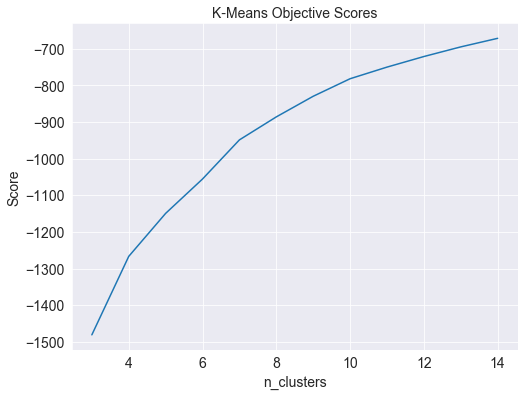

In [24]:
plt.figure(1, figsize = (8,6))
plt.plot(range(3,15), [i/1000 for i in scores])
plt.title("K-Means Objective Scores", fontsize = 14)
plt.xlabel("n_clusters", fontsize = 14)
plt.ylabel("Score", fontsize = 14)
plt.tick_params(labelsize=14)
plt.show()

In [25]:
## Making cluster label features
# From using the above elbow method, it looks like n_clusters should be around 6.

kmeans_model = KMeans(n_clusters = 6, n_jobs = 4)

kmeans_model.fit(X_scaled)

model_df['Kmeans_labels'] = kmeans_model.fit_predict(X_scaled)

In [26]:
model_df['Kmeans_labels'].value_counts()

1    37378
0    37305
2    29856
3    29342
4        3
5        1
Name: Kmeans_labels, dtype: int64

In [27]:
## For analysis and ML, we'll need to vectorize these labels such that it's possible to groupby each and obtain
## aggregate stats, and for the ML model to read.

clustered_model_df = pd.concat([
    model_df,
    pd.get_dummies(model_df['Kmeans_labels']).rename(columns = {i : 'cluster_' + str(i) for i in range(0,6)})],
    axis = 1
)

In [28]:
## Using these labels obtained, we can easily table the average properties per cluster label.
## We can see that many of these values differ significantly, including our targets of HOMO, LUMO, alpha.
clustered_df = df.copy()
clustered_df['Kmeans_labels'] = kmeans_model.fit_predict(X_scaled)
clustered_df.groupby('Kmeans_labels').mean()

,n_atoms,A,B,C,u,alpha,HOMO,LUMO,HL_gap,<R2>,zpve,U_0K,U_298K,H,G,Cv,HF_below_1000,HF_1000_2000,HF_above_2000,num_C,num_H,num_O,num_N,num_F
Kmeans_labels,,,,,,,,,,,,,,,,,,,,,,,,
0,14.191360,33.212366,1.584284,1.193947,3.512927,67.525274,-0.242868,-0.027135,0.215733,1045.487176,0.106533,-421.240248,-421.232732,-421.231788,-421.272610,27.481476,16.635233,13.966307,6.025176,4.921916,5.633496,1.426634,2.161449,0.047866
1,18.147513,3.373462,1.571767,1.277978,2.410036,76.510113,-0.233638,0.023718,0.257356,1069.159873,0.151775,-386.216202,-386.208324,-386.207380,-386.248623,30.384720,19.152860,19.547707,9.771099,6.882258,9.433968,0.886987,0.942768,0.001532
2,21.866308,3.079793,1.191206,0.994958,1.804838,83.902172,-0.239950,0.048059,0.288009,1385.888632,0.192176,-394.146229,-394.136628,-394.135684,-394.180883,36.062298,21.874894,24.976203,13.202515,7.518068,12.925734,1.084812,0.337694,0.000000
3,17.807078,3.215106,1.246844,1.004370,3.088719,73.332825,-0.243578,-0.000560,0.243017,1269.155516,0.144699,-440.797102,-440.788169,-440.787225,-440.831353,32.579020,19.234870,19.161907,9.093100,5.950602,8.854910,2.174783,0.826297,0.000486
4,4.000000,416.969890,296.384980,210.682137,1.158900,9.660000,-0.312500,0.089567,0.402067,26.840200,0.033494,-57.803173,-57.800318,-57.799374,-57.821969,6.262333,0.000000,3.000000,3.000000,0.333333,3.000000,0.333333,0.333333,0.000000
5,13.519766,3.072643,1.370746,1.065627,2.442003,56.582313,-0.266589,0.002721,0.269310,1119.788300,0.093360,-543.370803,-543.362825,-543.361881,-543.404177,28.685886,16.837482,13.001464,4.918009,4.528551,4.726208,0.657394,0.922401,2.685212


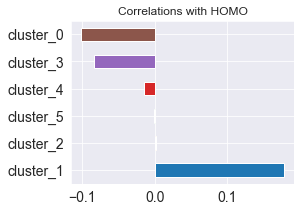

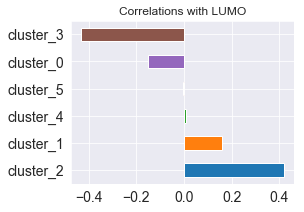

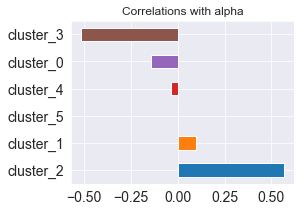

In [29]:
cols = ['cluster_' + str(i) for i in range(0,6)]
cluster_viz_df = clustered_model_df[cols].copy()
cluster_viz_df['HOMO'] = df['HOMO']
cluster_viz_df['LUMO'] = df['LUMO']
cluster_viz_df['alpha'] = df['alpha']

for i in ['HOMO','LUMO','alpha']:
    cols = ['HOMO','LUMO','alpha']
    cols.remove(i)
    plt.figure(figsize = (4,3))
    cluster_viz_df.drop(cols,axis = 1).corr()[i].sort_values(ascending = False)[1:].plot(kind = 'barh')
    plt.title('Correlations with {}'.format(i))
    plt.tick_params(labelsize=14)

#### Part II. Methodology: Modeling

In [30]:
clustered_model_df.head()

,n_atoms,A,B,C,u,<R2>,zpve,G,Cv,HF_below_1000,HF_1000_2000,HF_above_2000,num_C,num_H,num_O,num_N,num_F,Kmeans_labels,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,5,157.71180,157.709970,157.706990,0.0000,35.3641,0.044749,-40.498597,6.469,0,5,4,1,4,0,0,0,4,0,0,0,0,1,0
1,4,293.60975,293.541110,191.393970,1.6256,26.1563,0.034358,-56.544961,6.316,0,3,3,0,3,0,1,0,4,0,0,0,0,1,0
2,3,799.58812,437.903860,282.945450,1.8511,19.0002,0.021375,-76.422349,6.002,0,1,2,0,2,1,0,0,4,0,0,0,0,1,0
3,4,0.00000,35.610036,35.610036,0.0000,59.5248,0.026841,-77.327429,8.574,4,0,3,2,2,0,0,0,3,0,0,0,1,0,0
4,3,0.00000,44.593883,44.593883,2.8937,48.7476,0.016601,-93.431246,6.278,2,0,2,1,1,0,1,0,3,0,0,0,1,0,0


In [33]:
def model_train(target):
    """target can be 'HOMO', 'LUMO', or 'alpha'"""
    
    print("Building models to predict ", target,'\n')
    
    X = clustered_model_df
    y = df[target]

    X_scaled = ss.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

    baseline_mean = y_train.mean()
    
    baseline_all = [baseline_mean for i in range(0,y.shape[0])]
    baseline_train = [baseline_mean for i in range(0,y_train.shape[0])]
    baseline_test = [baseline_mean for i in range(0,y_test.shape[0])]

    print("Mean : ", baseline_mean)
    print("Baseline Accuracy: ", r2_score(y, baseline_all))
    print("Baseline RMSE    : ", np.sqrt(mean_squared_error(y, baseline_all)) )
    print('')

    print("Scores :                R^2                 RMSE")
    ridge_model = RidgeCV(cv = 3, alphas=np.linspace(0.0001,1000,50))
    ridge_model.fit(X_train, y_train)
    print("Ridge")
    print("Training Score : ", 
          ridge_model.score(X_train, y_train)*100,
          np.sqrt(mean_squared_error(y_train, ridge_model.predict(X_train))))
    print("Test Score     : ",
          ridge_model.score(X_test, y_test)*100,
          np.sqrt(mean_squared_error(y_test , ridge_model.predict(X_test))))
    print('')

    lasso_model = LassoCV(cv = 3, alphas=np.linspace(0.0001,1000,50))
    lasso_model.fit(X_train, y_train)
    print("Lasso")
    print("Training Score : ", 
          lasso_model.score(X_train, y_train)*100,
          np.sqrt(mean_squared_error(y_train, lasso_model.predict(X_train))))
    print("Test Score     : ",
          lasso_model.score(X_test, y_test)*100,
          np.sqrt(mean_squared_error(y_test , lasso_model.predict(X_test))))
    print('')
    
    enet_model  = ElasticNetCV(cv = 3, max_iter=1000000, alphas=np.linspace(0.0001,1000,50))
    enet_model.fit(X_train, y_train)
    print("E-Net")
    print("Training Score : ", 
          enet_model.score(X_train, y_train)*100,
          np.sqrt(mean_squared_error(y_train, enet_model.predict(X_train))))
    print("Test Score     : ",
          enet_model.score(X_test, y_test)*100,
          np.sqrt(mean_squared_error(y_test , enet_model.predict(X_test))))
    print('')
    
    dt_model = DecisionTreeRegressor(max_depth = 5)
    dt_model.fit(X_train, y_train)
    print("Decision Tree")
    print("Training Score : ", 
          dt_model.score(X_train, y_train)*100,
          np.sqrt(mean_squared_error(y_train, dt_model.predict(X_train))))
    print("Test Score     : ",
          dt_model.score(X_test, y_test)*100,
          np.sqrt(mean_squared_error(y_test , dt_model.predict(X_test))))
    print('')

### Part IV. Analysis and Results

In [34]:
model_train('HOMO')

Building models to predict  HOMO 

Mean :  -0.23998926685091057
Baseline Accuracy:  -3.224616704766703e-07
Baseline RMSE    :  0.022131354939868175

Scores :                R^2                 RMSE
Ridge
Training Score :  39.45036702847356 0.017282311139614873
Test Score     :  39.12377768615082 0.017123769745546257

Lasso
Training Score :  33.73886482357247 0.018079045513488667
Test Score     :  33.6396789292456 0.01787844618503613

E-Net
Training Score :  36.27658894250107 0.017729462513312266
Test Score     :  36.184195063570854 0.017532330869999564

Decision Tree
Training Score :  25.168271567116896 0.019212724285113073
Test Score     :  24.437438554272227 0.01907782531891665



In [35]:
model_train('LUMO')

Building models to predict  LUMO 

Mean :  0.011178668146266849
Baseline Accuracy:  -1.3681890209671366e-06
Baseline RMSE    :  0.04693592669409776

Scores :                R^2                 RMSE
Ridge
Training Score :  59.57136405126382 0.029826177771194676
Test Score     :  57.03625197832014 0.030806391361532872

Lasso
Training Score :  58.76945834468804 0.030120527810677936
Test Score     :  58.04124568517932 0.030443952878279598

E-Net
Training Score :  58.91910091120034 0.030065818242646473
Test Score     :  57.73843377904503 0.03055361078566141

Decision Tree
Training Score :  54.7536630572923 0.031553298820519375
Test Score     :  53.82994395021286 0.031935222683702615



In [36]:
model_train('alpha')

Building models to predict  alpha 

Mean :  75.19212315538977
Baseline Accuracy:  -1.020110795835194e-08
Baseline RMSE    :  8.187762265812706

Scores :                R^2                 RMSE
Ridge
Training Score :  93.68581873140049 2.0581713725627324
Test Score     :  93.28929342629289 2.1192428023896572



/Users/robertmanriquez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/robertmanriquez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/robertmanriquez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso
Training Score :  0.0 8.190737551919984
Test Score     :  -1.1353539752789743e-05 8.180815847045343

E-Net
Training Score :  93.88814405402763 2.024927904612895
Test Score     :  92.66997620192868 2.2148753221897803

Decision Tree
Training Score :  82.92529457809226 3.384539760248233
Test Score     :  83.06711547897869 3.3663716853671506



In [37]:
# Lasso method threw an error for fitting problems, which can be fixed with more model training tuning.

#### Part V. Conclusion

Using Sci-kit Learn's open source ML package, it was possible to create several machine learning models to predict HOMO, LUMO, and Polarizability values using a dataset of 134,000+ computationally generated molecules.  Although accuracies ranging from 25 - 60% may not seem impressive at first glance, all of the models produced improved over the baseline (which was just a measure of central tendency for each target) and were shown to have lower RMSE values. The HOMO vales were the most difficult to predict, with scores of 39.1% accuracy and RMSE 0.017 using the Ridge model and relatively weak alpha tuning.  LUMO was possible to predict with 58.0% accuracy and RMSE 0.030, while Polarizability enjoyed the highest predictive power with 93.3% accuracy and RMSE 2.12.

This work demonstrates with relatively little parameter tuning and cross validation, it's possible to get some predictive power out of these models.  There is still plenty to do in regards of cluster analysis, since each target variable did show highest correlations with the different cluster labels.  For parameter tuning, emplying GridSearch methods as well as introducing other methods like polynomial fitting or Principal Component Analysis could be used to potentially improve model performance (especially for the decision tree model, which often requires extensive tuning and ensemble a la the Random Forest method).  However, the purpose of this work is to showcase how Python, Pandas, and Sci-Kit Learn in the Jupyter environment can greatly boost productivity and efficiency of chemical analytics all with open source tools and a Macbook.  This will never replace modern scientific computational software nor skillful scientific reasoning, but has enourmous potential to improving the pace of scientific discovery.

#### Part VI. References

[1] "Quantum chemistry structures and properties of 134 kilo molecules", Ramakrishnan et al. (doi: 10.1038/sdata.2014.22)


[2] https://scikit-learn.org/stable/